# Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

# Read in data

In [2]:
xls_file = pd.ExcelFile("data_oil_2022/RBRTEd.xls")
brent = xls_file.parse(sheet_name="Data 1")
brent = brent.iloc[2:] # remove first two rows
brent.columns = ["date", "oil_price"] # change colnames
brent["date"] = brent["date"].astype("datetime64[ns]") # specify date format

In [3]:
brent

,date,oil_price
2,1987-05-20,18.63
3,1987-05-21,18.45
4,1987-05-22,18.55
5,1987-05-25,18.6
6,1987-05-26,18.63
...,...,...
7638,2017-06-20,43.98
7639,2017-06-21,44.62
7640,2017-06-22,44.46
7641,2017-06-23,44.14


# Data Manipulation

In [4]:
shares = ["BP.L","CNE.L","ENGI.PA","FP.PA","PMO.L","RDSB.L","REP.MC","SLB.PA","STL.OL"]

all_data = pd.DataFrame() # master data frame for all shares

for idx in range(len(shares)):
    
    stock = pd.read_csv("data_oil_2022/" + shares[idx] + ".csv") # read in data
    
    stock = stock[["Date","Close"]]
    stock["Date"] = stock["Date"].astype("datetime64[ns]")
    stock.columns = ["date", "share_price"]
    merged = stock.merge(brent, on ="date", how="left") # merge with brent oil data
    stock["oil_price"] = merged["oil_price"]
    stock["share_price"] = pd.to_numeric(stock["share_price"], errors="coerce").dropna(0)
    stock["oil_price"] = pd.to_numeric(stock["oil_price"], errors="coerce").dropna(0)
    stock["year"] = pd.to_datetime(stock["date"]).dt.year # extract year to distinct column
    stock["name"] = shares[idx] # assign name identifier to each of the shares
    stock = stock.dropna()
    
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    stock["share_price_scaled"] = scaler.fit_transform(stock["share_price"].to_frame()) # scale share price to range [0,1]
    all_data = all_data.append(stock) # append share data to master data frame

In [5]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38565 entries, 1 to 4454
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                38565 non-null  datetime64[ns]
 1   share_price         38565 non-null  float64       
 2   oil_price           38565 non-null  float64       
 3   year                38565 non-null  int64         
 4   name                38565 non-null  object        
 5   share_price_scaled  38565 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 2.1+ MB


In [6]:
all_data.head()

,date,share_price,oil_price,year,name,share_price_scaled
1,2000-01-04,279.134583,23.95,2000,BP.L,0.306272
2,2000-01-05,279.134583,23.72,2000,BP.L,0.306272
3,2000-01-06,281.944702,23.55,2000,BP.L,0.315041
4,2000-01-07,279.603088,23.35,2000,BP.L,0.307734
5,2000-01-10,271.407043,22.77,2000,BP.L,0.282159


# Data Exploration

## Time Series: Brent Oil

<AxesSubplot:xlabel='date'>

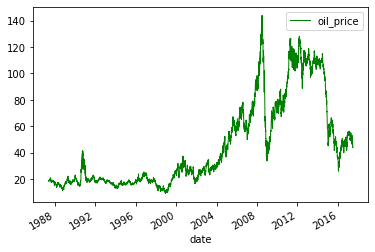

In [7]:
brent[["date","oil_price"]].set_index("date").plot(color = "green", linewidth = 1.0)

### Interpretations

- The oil price rised towards 2008 due to consumer fear about the wars in Afghanistan and Iraq
- The great financial crisis plunged the oil price in 2008
- The price declined dramatically in 2014 due to oversupply of petroleum relative to the demand. The oversupply originated mostly from US but also a few OPEC countries. Concurrently the demand dropped in Europe and China due to economic slowdown and changes in attitudes

## Pair plot: BP and Brent Oil

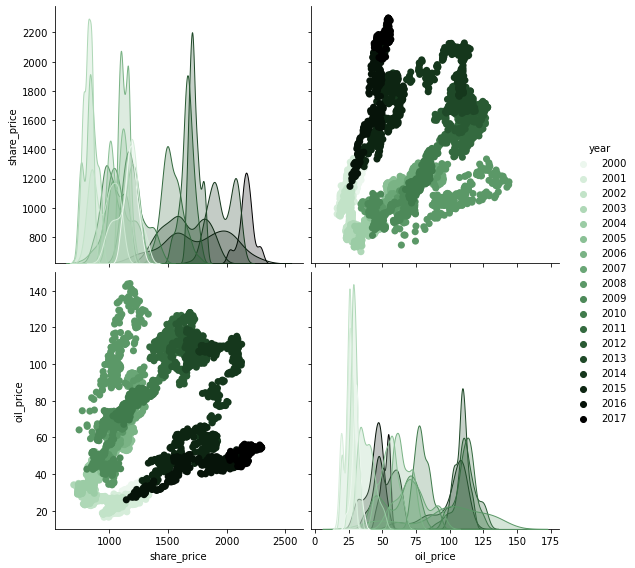

In [8]:
color_palette = sns.cubehelix_palette(18, start=2, rot=0, dark=0, light=.95, reverse=False)
sns.pairplot(all_data[all_data["name"]=="RDSB.L"].drop(["share_price_scaled"], axis=1),
             hue="year", palette=color_palette, size=4, markers="o", 
             plot_kws=dict(s=50, edgecolor="b", linewidth=0))
             

### What does the charts represent?

- The diagonal elements show the kernel density estimates of the distributions of BP's stock price and Brent oil price during years 2000-2017
- The off-diagonal scatter plots show the covariance structure of the BP' stock price and Brent oil price during years 2000-2017

### Interpretations

- BP's stock price has increased over time since the distributions' locations have shifted to the right over the years
- BP's stock price and oil prices seem to be positively correlated - when oil prices increase in any given year, so does typically the price of BP's stock
- The standard deviations of the price of both BP's stock and oil seem to vary a lot between different years. This can be seen from the shape of the densities: some distributions are considerably wider whereas others are narrow with high peaks (kurtosis)

## Pair plot: Royal Dutch Shell and Brent Oil 2013-2017

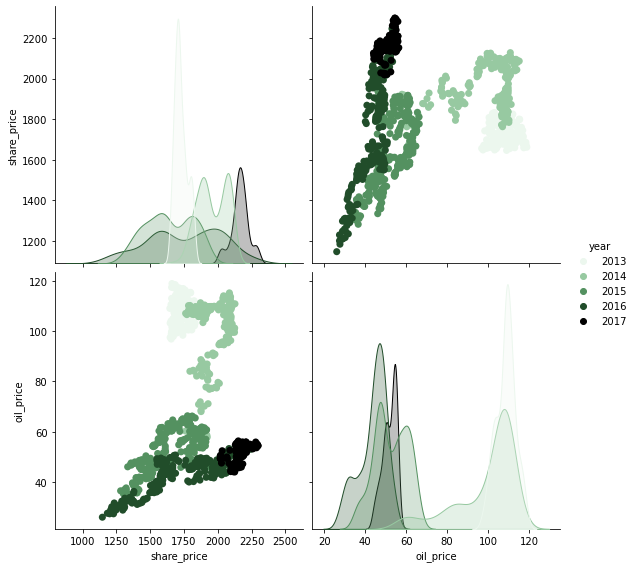

In [9]:
last5 = all_data.query("year > 2012")

shell_sub = last5.query("name == 'RDSB.L'")
color_palette = sns.cubehelix_palette(5, start=2, rot=0, dark=0, light=.95, reverse=False)
sns.pairplot(shell_sub.drop(["share_price_scaled"], axis=1),
             hue="year", palette=color_palette, size=4, markers="o", 
             plot_kws=dict(s=50, edgecolor="b", linewidth=0))

### Interpretations

- Shell's share price was most unstable in 2015-2016 and most stable in 2017
- Strong positive correlation between Shell's share price and Brent oil price each year except 2014
- Somewhere in 2014, the linear relationshup between Shell's share price and Brent oil price diminished
- The Brent oil price distribution has strong negative skewness in 2014

## Violin plot: Oil price 2013-2017

<AxesSubplot:xlabel='year', ylabel='oil_price'>

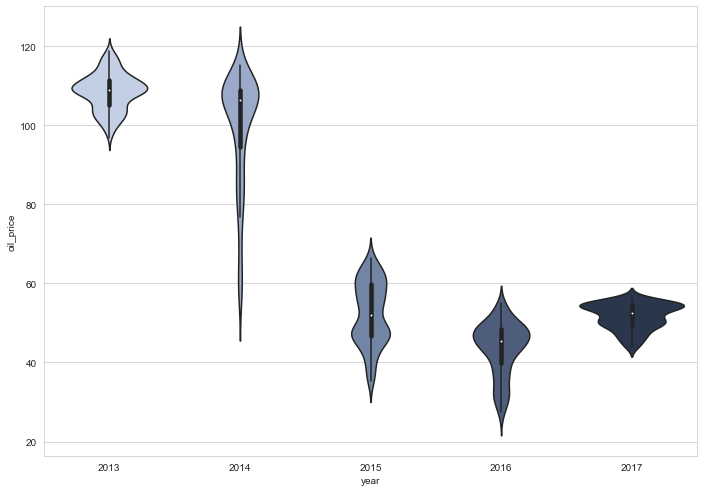

In [10]:
sns.set_style("whitegrid")
color_palette = sns.cubehelix_palette(5, start=2.8, rot=0, dark=0.2, light=0.8, reverse=False)
plt.figure(figsize=(11.7, 8.27))
sns.violinplot(x="year", y="oil_price", data=last5.query("name == 'RDSB.L'"),
              inner="box", palette=color_palette, trim=True)

## Violin plot: All Stocks 2013-2017

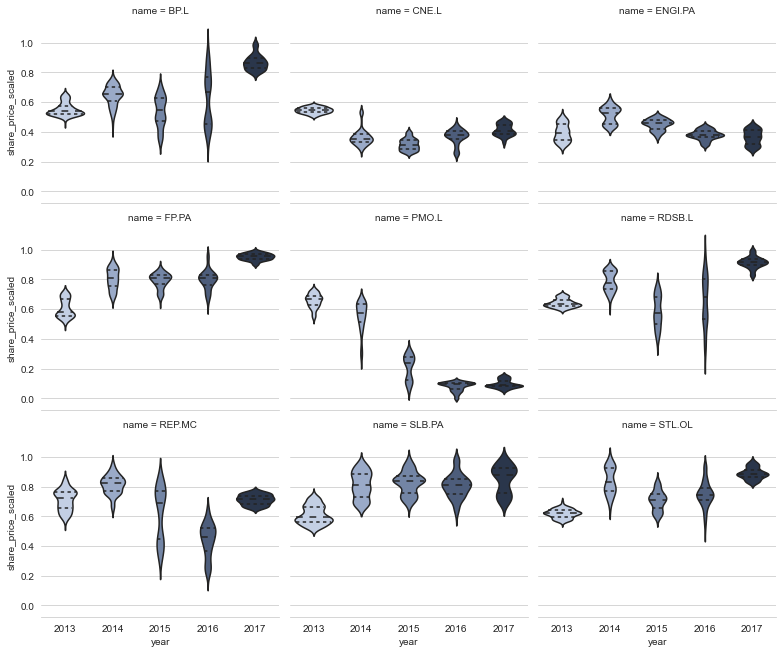

In [11]:
sns.catplot(x="year", y="share_price_scaled", col="name", col_wrap=3, kind="violin",
              split=True, data=last5, inner="quart", palette=color_palette, trim=True,
              size=3, aspect=1.2)
sns.despine(left=True)

## Interpretations

- Some companies share prices have low volatility (e.g., SLB.PA) and other have high volatility (e.g., RDSB.L)
- Some companies' shares have gone up or down in value (e.g., FP.PA, PMO.L) while others have more or less kept their value (e.g., SLB.PA, ENGI.PA
- Some years are bad for many companies (e.g., 2016) which shows systematic risk
- Some years are steady for all firms (e.g., 2013)
- Some companies' shares seem to follow the oil price (declining prices) while others have succeeded insted (varying correlation wrt. annual price level)
- Although the oil prices surged most dramatically in 2014, the worst fluctuations in stock prices was in 2016. This suggests that oil prices are likely affected by some other risk than oil price risk as well

## Joint plot: Premier Oil and Brent Oil 2013-2017

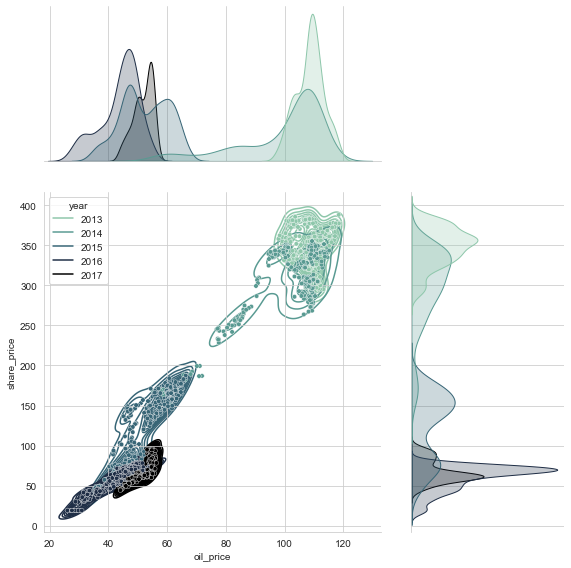

In [12]:
color_palette = sns.cubehelix_palette(5, start=0, rot=-.4, dark=0, light=0.7, reverse=False)
g = sns.jointplot(x="oil_price", y="share_price", data=last5.query("name == 'PMO.L'"), kind="scatter", 
              hue="year", palette=color_palette, size=8, ratio=2, s=20)
g.plot_joint(sns.kdeplot, zorder=0, levels=20)

### Interpretations

- Scatter plot shows diagonal-like structure, so there is strong correlation between Premier oil and Brent oil
- Prices of both oil types have declined in tandem between 2013-2017
- There are few observations in the middle (can be seen from both joint and marginal distributions) which suggests a steep negative price decline between 2014-2015

## lmplot: All Stocks 2013-2017

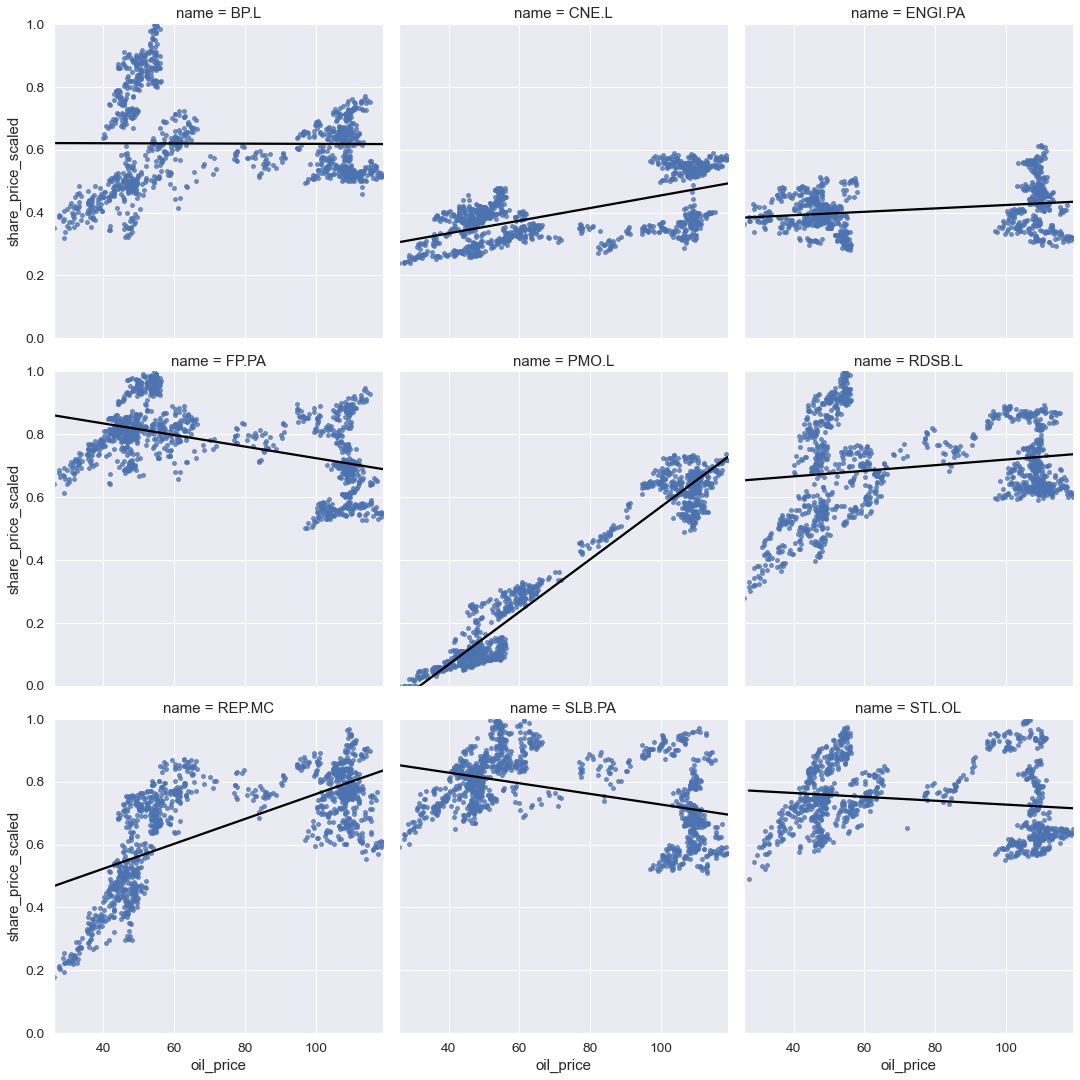

In [13]:
sns.set(font_scale=1.25)
fig = sns.lmplot(x="oil_price", y="share_price_scaled", col="name", ci=None, col_wrap=3,
                 data=last5, order=1, line_kws={"color": "black"},
                 scatter_kws={"s": 15, "alpha": .75})
fig.set(ylim = (0,1))

### Interpretations

- As we saw earlier, the share price of Premier Oil is strongly positively correlated with Brent oil price
- Most stocks have a weak relationship with the oil price, in either direction
- Some stocks appear to have no linear relationship with brent oil, e.g., BPL
- ENGL.PA seems to have a gap, indicates a strong price surge in both the share price and brent oil price
- The error term is autocorrelated in almost all regressions. Something probably needs to be done to address this issue. Otherwise, we have underestimated standard errors and inference/prediction could be spurious
- Yearwise regression might work

## lmplot: All Stocks 2013-2017, Yearwise

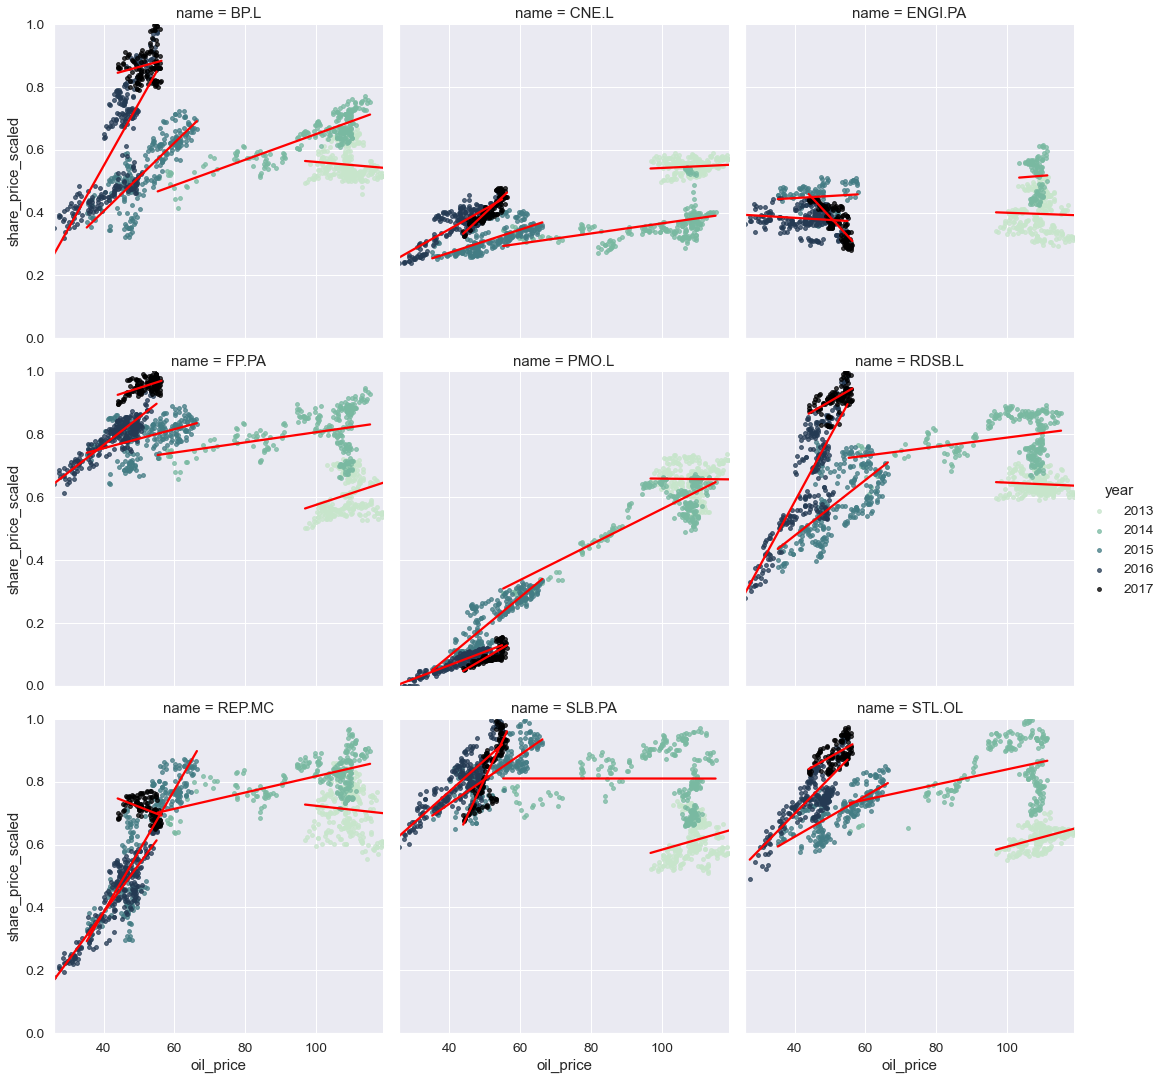

In [14]:
sns.set(font_scale=1.25)
color_palette = sns.cubehelix_palette(5, start=0, rot=-.4, dark=0, light=0.85, reverse=False)
fig = sns.lmplot(x="oil_price", y="share_price_scaled", hue="year", col="name", ci=None, 
                 col_wrap=3, palette=color_palette, data=last5, order=1, 
                 line_kws={"color": "red"}, 
                 scatter_kws={"s": 15, "alpha": .75})
fig.set(ylim = (0,1))

### Interpretations

- Yearwise regression seems better but definitely autocorrelation/heteroscedasticity in 2014 for many companies
- Some fits are still quite bad, e.g., ENGI.PA and SLP.PA in 2014

# Model Fitting

## Cluster Analysis: Royal Dutch Shell 

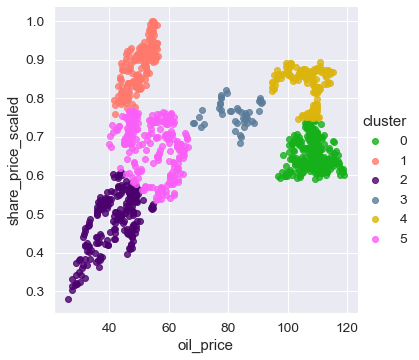

In [15]:
from sklearn.cluster import KMeans

shell = pd.DataFrame()
shell = last5.query("name == 'RDSB.L'")
shell["oil_price_scaled"] = scaler.fit_transform(shell["oil_price"].to_frame()) # standardize oil price for model fitting
shell["cluster"] = KMeans(n_clusters=6, random_state=1).fit_predict(shell[["share_price_scaled", "oil_price_scaled"]])

colors = ["green", "salmon", "royal purple", "slate blue", "gold", "light magenta"]
color_palette = sns.xkcd_palette(colors)

sns.lmplot(x="oil_price", y="share_price_scaled", data=shell, hue="cluster", ci=None, fit_reg=False, palette=color_palette)

### Rough Interpretation

- Salmon: high share price with low oil price
- Purple: low share price with low oil price
- Pink: medium share price with low oil price
- Slate blue: medium oil price
- Yellow: high share price with high oil price
- Green: medium share price with high oil price

## Linear Regression: Royal Dutch Shell

In [16]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

last2_shell = all_data.query("name == 'RDSB.L' & year > 2015")
last2_shell = last2_shell[["share_price", "oil_price"]].reset_index(drop=True)

x, y = last2_shell["oil_price"].to_frame(), last2_shell["share_price"].to_frame()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=100/len(last2_shell), random_state=1, shuffle=False)

reg = linear_model.LinearRegression()
reg.fit(x_train, y_train)

print("Intercept: {:.2f}, Slope: {:.2f}".format(float(reg.intercept_), float(reg.coef_)))
print("Training MSE: {:.2f}".format(mean_squared_error(y_true=y_train, y_pred=reg.predict(x_train))))
print("Test MSE: {:.2f}".format(mean_squared_error(y_true=y_test, y_pred=reg.predict(x_test))))

Intercept: 225.80, Slope: 35.25
Training MSE: 23210.67
Test MSE: 24557.62


### Prediction

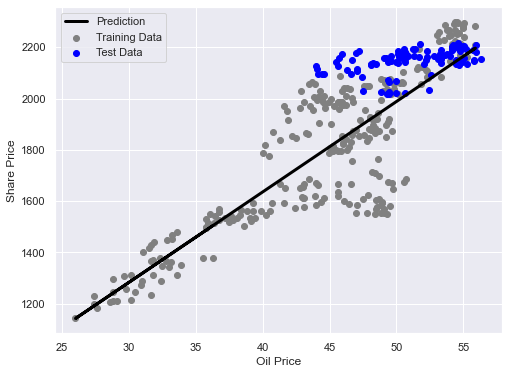

In [17]:
sns.set(font_scale=1)
plt.figure(figsize=(8,6))
plt_train = plt.scatter(x_train, y_train, color="grey", label="Training Data")
plt_test = plt.scatter(x_test, y_test, color="blue", label="Test Data")
plt_pred = plt.plot(x_train, reg.predict(x_train), color="black", linewidth=3, label="Prediction")
plt.xlabel("Oil Price")
plt.ylabel("Share Price")
plt.legend()
plt.show()

### Interpretations

- The test data is not well predicted by the regression line
- The residuals are heteroscedastic: the variance of the error term increases as a function of oil price
- With the test data, the intercept term should be higher and the slope smaller, i.e., oil price deltas do not affect the share price as much in the test data, and the base level seems to be higher
- The test data appears to come from another distribution. We should perhaps consider fitting different models to different subsets of the data

## Random Forest Regression

In [18]:
from sklearn.ensemble import RandomForestRegressor

# Add features
last2_shell["PMO.L"] = all_data.query("name == 'PMO.L' & year > 2015")["share_price"].reset_index(drop=True)
last2_shell["CNE.L"] = all_data.query("name == 'CNE.L' & year > 2015")["share_price"].reset_index(drop=True)
last2_shell["FP.PA"] = all_data.query("name == 'FP.PA' & year > 2015")["share_price"].reset_index(drop=True)
last2_shell["ENGI.PA"] = all_data.query("name == 'ENGI.PA' & year > 2015")["share_price"].reset_index(drop=True)
last2_shell.dropna(inplace=True)

X = last2_shell.drop("share_price", axis=1)
y = last2_shell["share_price"]

# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100/len(last2_shell), random_state=1, shuffle=False)

# fit model
regressor = RandomForestRegressor(n_estimators=200, max_depth=5)
regressor.fit(X_train, y_train)

# predict
y_pred = regressor.predict(X_test)
y_pred = pd.DataFrame(y_pred)

### Model Fitting

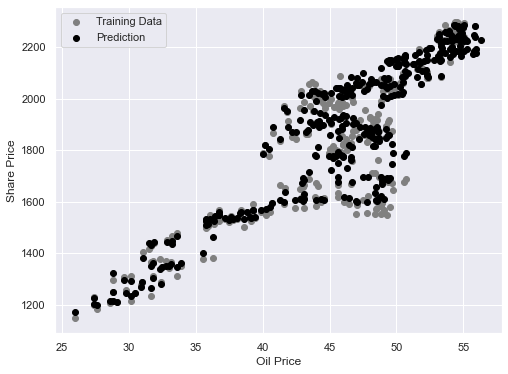

In [19]:
plt.figure(figsize=(8,6))
plt_train = plt.scatter(X_train["oil_price"], y_train, color="grey")
plt_pred = plt.scatter(last2_shell["oil_price"], regressor.predict(X), color="black")
plt.xlabel("Oil Price")
plt.ylabel("Share Price")
plt.legend((plt_train, plt_pred), ("Training Data", "Prediction"))
plt.show()

In [20]:
print("Training MSE: {:.2f}".format(mean_squared_error(y_true=y_train, y_pred=regressor.predict(X_train))))

Training MSE: 2098.35


### Prediction

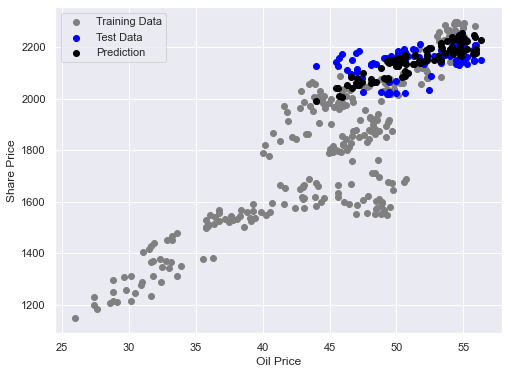

In [21]:
plt.figure(figsize=(8,6))
plt_train=plt.scatter(X_train["oil_price"],y_train,   color='grey')
plt_test=plt.scatter(X_test["oil_price"],y_test,   color='blue')
plt_pred=plt.scatter(X_test["oil_price"], y_pred,  color='black')
plt.xlabel("Oil Price")
plt.ylabel("Share Price")
plt.legend((plt_train, plt_test, plt_pred),("Training Data", "Test Data", "Prediction"))
plt.show()

In [22]:
print("Test MSE: {:.2f}".format(mean_squared_error(y_true=y_test, y_pred=regressor.predict(X_test))))

Test MSE: 4659.66


### Feature Importance

In [23]:
importance = regressor.feature_importances_

print("Feature ranking:")
for idx, name in enumerate(list(X_train)):
    print("{}: {:.2f}%".format(name, 100*importance[idx]))

Feature ranking:
oil_price: 11.75%
PMO.L: 1.18%
CNE.L: 13.21%
FP.PA: 64.95%
ENGI.PA: 8.91%


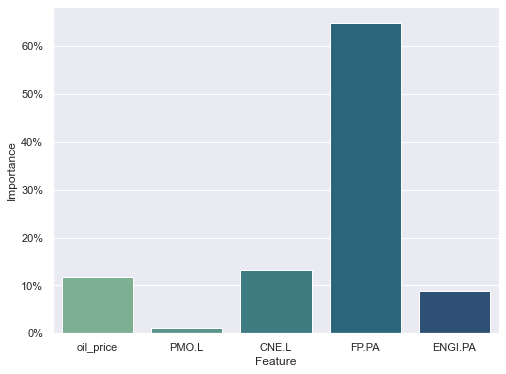

In [24]:
from matplotlib.ticker import PercentFormatter

plt.figure(figsize=(8,6))
ax = sns.barplot(list(X_train), importance, palette="crest")
plt.xlabel("Feature")
plt.ylabel("Importance")
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

### Interpretations

- Random Forest Regression seem to catch the nonlinearities in the data better than Linear Regression
- Random Forest Regression is better fit than Linear Regression on the training set
- Random Forest Regression performs considerably better than Linear Regression on the test set as well
- The most important feature for the Random Forest Regessor is clearly the price of share FP.PA